# Feature Analysis

In [1]:
import pandas as pd
import math

In [2]:
dilatz = 0

In [3]:
filenames1 = ['pionminus','pionminus1','pionminus2','pionminus3','pionminus4','pionminus5']
filenames1 = ['ccbar0','phi0']
filenames1 = ['ccbar0']
filenames2 = ['dalitz_25M_v0']
filenames2 = ['photon_100M_v0','photon_100M_v1']
filepath = "/home/yoren/bnl/PHENIX/ee/ML/"

hadron_weight = 25000*50/500

In [ ]:
if True:
    data = pd.read_csv(filepath+f'{filenames1[0]}.csv')
    for ifile in range(1,len(filenames1)):
        idata = pd.read_csv(filepath+f'{filenames1[ifile]}.csv')
        data = pd.concat([data,idata], sort=False)
    data.loc[data['IsTrue0'] > -99, 'IsTrue0'] = 1

    for ifile in range(0,len(filenames2)):
        idata = pd.read_csv(filepath+f'{filenames2[ifile]}.csv')
        idata.loc[idata['IsTrue0'] > -99, 'IsTrue0'] = 0
        data = pd.concat([data,idata], sort=False)

    data = data.sample(frac = 1)
    float_columns=('Pt', 'Phi0', 'The0', 'PhiDC', 'ZDC', 'Alpha', 'Ecore',\
                   'sdphi0','sdthe0','SecondHitPhiR0','SecondHitPhiL0','SecondHitTheR0','SecondHitTheL0',\
                   'sdphi1','sdthe1','SecondHitPhiR1','SecondHitPhiL1','SecondHitTheR1','SecondHitTheL1',\
                   'sdphi2','sdthe2','SecondHitPhiR2','SecondHitPhiL2','SecondHitTheR2','SecondHitTheL2',\
                   'sdphi3','sdthe3','SecondHitPhiR3','SecondHitPhiL3','SecondHitTheR3','SecondHitTheL3')
    int_columns=('NBDThit','Centrality', 'Charge', 'Arm','IsTrue0','IsTrue1','IsTrue2','IsTrue3')
    
    for float_column in float_columns:
        data[float_column] = data[float_column].astype('float16')
    for int_column in int_columns:
        data[int_column] = data[int_column].astype('int32')
        
    data = data[(data['Pt'] < 25) & (data['Ecore'] > 0.1) & (data['Ecore'] < 25) ]
    if dilatz:
        data = data[(data['Pt'] < 5)  ]
    

    data.head()

In [ ]:
data.head()

NBDThit        Pt      Phi0      The0     PhiDC        ZDC  \
5834482         3  2.423828 -0.369629  1.474609 -0.453369  21.203125   
154309          1  0.586914  0.870605  1.899414  0.497070 -74.125000   
2169903         1  0.792480  2.111328  1.681641  2.371094 -24.218750   
14346163        3  2.003906 -0.368408  1.287109 -0.472900  64.250000   
14117938        3  1.375977  3.048828  1.361328  3.199219  46.750000   

             Alpha     Ecore  Centrality  Charge  ...  SecondHitPhiL2  \
5834482   0.042358  2.292969          33      -1  ...       -99.00000   
154309    0.194214  0.678223          51      -1  ...       -99.00000   
2169903  -0.130981  0.763672          58       1  ...       -99.00000   
14346163  0.055542  2.035156          11      -1  ...        57.46875   
14117938 -0.076721  1.266602          27       1  ...        45.71875   

          SecondHitTheR2  SecondHitTheL2     sdphi3     sdthe3  IsTrue3  \
5834482        -5.320312      -99.000000 -10.000000 -10.000000        0   
154309          0.000000      -99.000000 -10.000000 -10.000000        0   
2169903       -99.000000      -99.000000  -0.968262  -1.968750        0   
14346163      -99.000000      -34.843750  -0.605469   0.257324        0   
14117938        0.000000       -0.819336  -0.221924   0.472412        1   

          SecondHitPhiR3  SecondHitPhiL3  SecondHitTheR3  SecondHitTheL3  
5834482       -99.000000       20.218750      -99.000000      -10.335938  
154309        -99.000000      -99.000000      -99.000000      -99.000000  
2169903       -21.187500      -99.000000       20.328125      -99.000000  
14346163        7.117188        0.865234      -41.937500      -41.468750  
14117938        0.000000        4.679688        0.000000       -7.496094  

[5 rows x 39 columns]

In [ ]:
print(data.size, data.shape)

1037155860 (26593740, 39)


In [ ]:
# удалим лишние колонки
data = data.drop(columns = ['IsTrue1','IsTrue2','IsTrue3'])

In [ ]:
import matplotlib.pyplot as plt

def analysis(data: pd.DataFrame):
    fig, ax = plt.subplots(4, 3, figsize=(15, 6))
    for i, feature in enumerate(['IsTrue0', 'Pt', 'Phi0', 'The0', 'PhiDC', 'ZDC', 'Alpha', 'Ecore' , 'sdphi0', 'sdphi1', 'sdphi2', 'sdphi3']):
        x, y = divmod(i, 3)
        data[feature].plot.hist(ax=ax[x][y], ylabel='', title=feature, color='skyblue', logy=True)


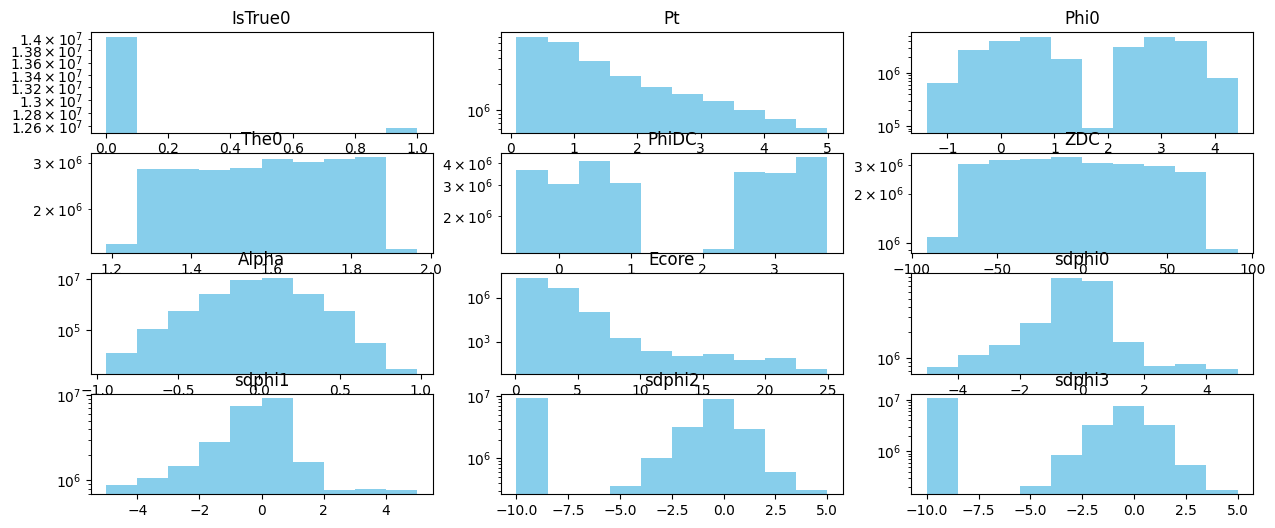

In [ ]:
analysis(data)

+ Видим, что impressions имеют только одно значение, поэтому их можно удалить.
+ Таргет-переменная clicks сильно несбалансирована. Возможно, стоит использовать балансировку весов, а также в качестве оценки моделей использовать f1 и ROC AUC.
+ У campaign_clicks нулевых значений сильно больше, чем ненулевых, следовательно, можно трансформировать в бинарную фичу
+ os_id со значениями больше 6 встречается редко, можно объединить в одну категорию
+ Аналогично с редкими значениями zone_id

# Feature Engineering

In [ ]:
def feature_engineering(data: pd.DataFrame) -> pd.DataFrame:
    # делим выборку на train и test
    #data = data.sort_values(by='date_time', ignore_index=True)
    #cut_off_val = data[data['date_time'] < pd.to_datetime('2021-10-01')].index[-1]
    #cut_off_test = data[data['date_time'] < pd.to_datetime('2021-10-02')].index[-1]

    cut_off_val =  int (data.shape[0]/3)
    cut_off_test = int (data.shape[0]/3*2 + 1)

    print(cut_off_val,cut_off_test)

    y = data['IsTrue0']
    data = data.drop(columns = ['IsTrue0'])
    data_train, data_test = data[:cut_off_test], data[cut_off_test:]
    y_train, y_test = y.iloc[:cut_off_test], y.iloc[cut_off_test:]
    
    # делаем one hot encodings
    #enc = OneHotEncoder(drop='first', handle_unknown='ignore')
    #enc.fit(data_train)
    #transformed_train = enc.transform(data_train)
    #transformed_test = enc.transform(data_test)
    
    return data_train, data_test, y_train, y_test,cut_off_val

In [ ]:
X_train_all, X_test, y_train_all, y_test, cut_off_val = feature_engineering(data)

1869994 3739990


In [ ]:
X_test

NBDThit        Pt      Phi0      The0     PhiDC        ZDC     Alpha  \
57473          2  1.143555  3.160156  1.581055  2.982422  -2.378906  0.086365   
3968933        3  1.804688 -0.089294  1.720703  0.023773 -33.218750 -0.057556   
1599083        3  1.352539  0.660645  1.553711  0.810059   3.816406 -0.075867   
272812         6  1.399414  0.653809  1.753906  0.504883 -40.625000  0.075012   
4305734        5  0.947266  2.226562  1.874023  2.455078 -68.375000 -0.120178   
...          ...       ...       ...       ...       ...        ...       ...   
355596         6  0.793945  0.955566  1.861328  0.690430 -65.437500  0.137695   
948890        24  0.393066  3.158203  1.294922  2.593750  58.187500  0.280762   
4556317        3  1.538086  0.439453  1.466797  0.307129  22.796875  0.065796   
304260         6  0.195801 -0.680176  1.937500  0.493408 -73.812500 -0.557129   
378293         2  1.178711  3.845703  1.563477  3.673828   1.577148  0.086670   

            Ecore  Centrality  Charge  ...  SecondHitPhiR2  SecondHitPhiL2  \
57473    1.017578          42      -1  ...            -0.0      -99.000000   
3968933  1.952148          80       1  ...           -99.0      -99.000000   
1599083  1.130859          35       1  ...            -4.0        7.257812   
272812   1.753906          20      -1  ...            -0.0       49.312500   
4305734  0.951172          62       1  ...           -99.0      -99.000000   
...           ...         ...     ...  ...             ...             ...   
355596   0.745605          20      -1  ...            -0.0        5.617188   
948890   0.628906          10      -1  ...            -0.0        7.453125   
4556317  1.577148          30      -1  ...           -99.0       33.156250   
304260   0.377686          20       1  ...           -99.0      -99.000000   
378293   1.130859          72      -1  ...            -0.0      -99.000000   

         SecondHitTheR2  SecondHitTheL2     sdphi3     sdthe3  SecondHitPhiR3  \
57473          0.000000      -99.000000 -10.000000 -10.000000      -99.000000   
3968933      -99.000000      -99.000000 -10.000000 -10.000000      -99.000000   
1599083       13.945312       12.265625  -0.476318   0.330322      -99.000000   
272812         0.000000       -4.617188 -10.000000 -10.000000      -99.000000   
4305734      -99.000000      -99.000000  -0.537598   0.349121      -99.000000   
...                 ...             ...        ...        ...             ...   
355596         0.000000       34.187500  -1.657227  -1.093750       -0.000000   
948890         0.000000       -9.468750  -1.196289  -0.943359       -0.000000   
4556317      -99.000000        0.199707   0.353027   0.557129       -1.021484   
304260       -99.000000      -99.000000  -1.118164   0.515625        0.000000   
378293         0.000000      -99.000000 -10.000000 -10.000000      -99.000000   

         SecondHitPhiL3  SecondHitTheR3  SecondHitTheL3  
57473        -99.000000      -99.000000      -99.000000  
3968933      -99.000000      -99.000000      -99.000000  
1599083      -99.000000      -99.000000      -99.000000  
272812        21.812500      -99.000000        0.429443  
4305734      -99.000000      -99.000000      -99.000000  
...                 ...             ...             ...  
355596        25.078125        0.000000       -8.320312  
948890       -99.000000        0.000000      -99.000000  
4556317      -99.000000        5.089844      -99.000000  
304260         8.671875        0.000000       -0.864746  
378293       -99.000000      -99.000000      -99.000000  

[1869994 rows x 35 columns]

In [ ]:
X_train, X_val = X_train_all[:cut_off_val], X_train_all[cut_off_val:]
y_train, y_val = y_train_all[:cut_off_val], y_train_all[cut_off_val:]
w_train, w_val = y_train-1, y_val-1
w_test = y_test-1
w_train_all = y_train_all - 1
w_train = w_train*(-hadron_weight)+1
w_val = w_val*(-hadron_weight)+1
w_test = w_test*(-hadron_weight)+1
w_train_all = w_train_all*(-hadron_weight)+1

+ Увидели, что количество кликов меняется в зависимости от дня недели и часа, добавим в качестве фичей
+ Также, добавим интеракции между этими двумя переменными, так как в разные дни недели разные часы могут по-разному влиять на колличество кликов
+ banner_id удалила, так как предполагаю, что модель должна уметь предсказывать клики для новых баннеров тоже.
+ Так как все оставшиеся фичи являются категориальными, сделали one-hot-encoding


+ В качестве теста берем последний день датасета, в качестве валидации -- предпоследний

# Create Model

In [ ]:
from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier
gb_clf = GradientBoostingClassifier(n_estimators=20, learning_rate= 0.1, max_features=2, max_depth=2, random_state=0)
gb_clf.fit(X_train, y_train, w_train)

predicted = gb_clf.predict(X_test)

# calculating the main quality metrics
print(metrics.classification_report(y_test, predicted))

print('confusion matrix')
print(metrics.confusion_matrix(y_test, predicted))

              precision    recall  f1-score   support

           0       0.27      1.00      0.43    482177
           1       1.00      0.07      0.13   1387817

    accuracy                           0.31   1869994
   macro avg       0.64      0.53      0.28   1869994
weighted avg       0.81      0.31      0.20   1869994

confusion matrix
[[ 482137      40]
 [1293838   93979]]


In [ ]:
# search for parameters
# https://www.kaggle.com/hatone/gradientboostingclassifier-with-gridsearchcv
import time
from sklearn.model_selection import GridSearchCV

start = time.time() 

parameters = {
    "loss":["log_loss"],
    "learning_rate": [0.01, 0.2],
    "min_samples_split": [0.01, 0.2],
    "max_depth":[12],
    "max_features":["log2","sqrt"],
    "criterion": ['squared_error'],
    "n_estimators":[20]
    }

classif = GradientBoostingClassifier()
classif.set_params(init='zero')

clf = GridSearchCV(classif, parameters, cv=3, n_jobs=8)

clf.fit(X_train, y_train, sample_weight=w_train)
print('точность: ', clf.score(X_test, y_test))

# getting the best parameters ans score
print(clf.best_params_)
print(clf.best_score_)

stop = time.time()    
print('time of execution (sec)', stop - start)

точность:  0.5713944226792947
{'criterion': 'squared_error', 'learning_rate': 0.2, 'loss': 'log_loss', 'max_depth': 16, 'max_features': 'sqrt', 'min_samples_split': 0.01, 'n_estimators': 24}
0.5718442385313236
time of execution (sec) 2450.1068563461304


# Cross Validation

In [ ]:
predicted = clf.predict(X_test)
print(metrics.classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.34      1.00      0.51    482177
           1       1.00      0.32      0.49   1387817

    accuracy                           0.50   1869994
   macro avg       0.67      0.66      0.50   1869994
weighted avg       0.83      0.50      0.49   1869994



In [ ]:
y_pred_probs = clf.predict_proba(X_test)
y_pred = clf.predict(X_test)

# Model Evaluation

log loss: 0.011834126196371943
roc auc: 0.9749530470480311
f1 score: 0.9357867334687409


Text(0.5, 1.0, 'ROC AUC Curve')

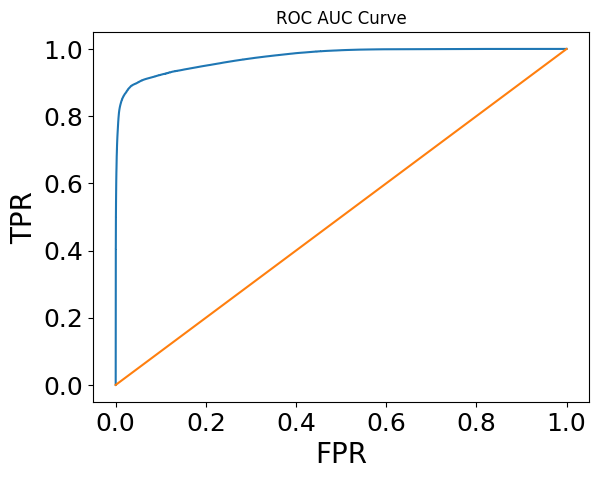

In [ ]:
import numpy as np
from sklearn import metrics
from sklearn.metrics import roc_auc_score, log_loss, f1_score

print('log loss:', log_loss(y_test, y_pred_probs, sample_weight=w_test))

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_probs[:, 1], pos_label=1, sample_weight=w_test)
metrics.auc(fpr, tpr)
print('roc auc:', metrics.auc(fpr, tpr))

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
y_pred_opt = y_pred_probs[:, 1] > optimal_threshold
print('f1 score:', f1_score(y_test, y_pred_opt))
plt.plot(fpr, tpr)
plt.plot(fpr, fpr)
plt.xlabel("FPR", fontsize=20)
plt.ylabel("TPR", fontsize=20)
plt.xticks(fontsize = 18) 
plt.yticks(fontsize = 18) 
plt.title('ROC AUC Curve')

In [ ]:
pred_baseline = np.ones_like(y_test) * y_test.mean()
print("baseline auc:", roc_auc_score(y_test, pred_baseline))
print("baseline log_loss:", log_loss(y_test, pred_baseline))

baseline auc: 0.5
baseline log_loss: 0.570795511711066


In [ ]:
i = 160000
print(round(tpr[i],3),round(fpr[i]/tpr[i],4))
print(thresholds[i],fpr[i],tpr[i])
#print((fpr[i]/tpr[i]*data1.shape[0]/data2.shape[0]/10)**-1,(fpr[i]/1.*data1.shape[0]/data2.shape[0]/10)**-1)

0.815 0.0094
0.022541462646646394 0.0076818263832576 0.8147594387444455


In [ ]:
print(sum(predicted),len(predicted))

448644 1869994


In [ ]:
kek_data = data
kek_data = kek_data.drop(columns = ['IsTrue0'])
proba_loc = clf.predict_proba(kek_data)
print(proba_loc[0][1])

0.008631085945402451


In [ ]:
import ROOT as root
outfile = root.TFile.Open("output/BDT_Conv.root", "recreate")
e_pt_hist_AI = root.TH2D("e_pt_hist_AI", "e_pt_hist_AI", 50, 0, 5, 10, 0, 100)
h_pt_hist_AI = root.TH2D("h_pt_hist_AI", "h_pt_hist_AI", 50, 0, 5, 10, 0, 100)
e_pt_hist_SC = root.TH2D("e_pt_hist_SC", "e_pt_hist_SC", 50, 0, 5, 10, 0, 100)
h_pt_hist_SC = root.TH2D("h_pt_hist_SC", "h_pt_hist_SC", 50, 0, 5, 10, 0, 100)
e_pt_hist_NC = root.TH2D("e_pt_hist_NC", "e_pt_hist_NC", 50, 0, 5, 10, 0, 100)
h_pt_hist_NC = root.TH2D("h_pt_hist_NC", "h_pt_hist_NC", 50, 0, 5, 10, 0, 100)

Welcome to JupyROOT 6.30/06


In [ ]:
mycute,mycuth, AIcute, AIcuth = 0, 0, 0, 0
norm_e, norm_h = 0, 0
data0 = data.reset_index()  # make sure indexes pair with number of rows

sigma, sigma_veto = 3, -2

counter =-1
for index, row in data0.iterrows():
    counter+=1
    if counter>4000000: break
    sdphi0, sdphi1, sdphi2, sdphi3 = row['sdphi0'], row['sdphi1'], row['sdphi2'], row['sdphi3']
    sdthe0, sdthe1, sdthe2, sdthe3 = row['sdthe0'], row['sdthe1'], row['sdthe2'], row['sdthe3']
    centrality, pt, IsTrue0 = row['Centrality'], row['Pt'], row['IsTrue0']

    if pt<0.4 or centrality<0: continue
    
    if IsTrue0: e_pt_hist_NC.Fill(pt,centrality)
    else:    h_pt_hist_NC.Fill(pt,centrality)
    if sdphi0>sigma_veto and ( abs(sdphi0) < sigma and abs(sdthe0) < sigma and abs(sdphi1) < sigma and abs(sdthe1) < sigma ) and ( ( abs(sdphi2) < sigma and abs(sdthe2) < sigma ) or ( abs(sdphi3) < sigma and abs(sdthe3) < sigma ) ):
        if IsTrue0: 
            mycute+=1
            e_pt_hist_SC.Fill(pt,centrality)
        else: 
            mycuth+=1+hadron_weight
            h_pt_hist_SC.Fill(pt,centrality)
    if proba_loc[counter][1]>thresholds[i]: 
        if IsTrue0: 
            AIcute+=1
            e_pt_hist_AI.Fill(pt,centrality)
        else: 
            AIcuth+=1+hadron_weight
            h_pt_hist_AI.Fill(pt,centrality)
    if IsTrue0: norm_e+=1
    else: norm_h+=1+hadron_weight
    #if counter<10: 
    #    print(proba_loc[counter],answer(centrality,pt,ep,n0,disp,chi2,npe0,prob))
        #print(centrality, pt, ep, n0, disp, chi2, npe0, prob, phi0 )

In [ ]:
print(norm_e, norm_h,round(mycute/norm_e,3),round(mycuth/norm_h,3), round(AIcute/norm_e,3), round(AIcuth/norm_h,3), round(AIcuth/AIcute/norm_h*norm_e,3),round(fpr[i]/tpr[i],3))

206446 182495469.0 0.753 0.498 0.855 0.008 0.009 0.009


In [ ]:
print(round(AIcute/mycute/(AIcuth/mycuth),3),round(AIcute/mycute,3),round(AIcuth/mycuth,3), round(30*AIcute/norm_e/AIcuth*norm_h))

71.938 1.136 0.016 3260


In [ ]:
%run input/Format.ipynb

/home/yoren/.local/lib/python3.10/site-packages/nbformat/__init__.py:96: MissingIDFieldWarning: Cell is missing an id field, this will become a hard error in future nbformat versions. You may want to use `normalize()` on your notebooks before validations (available since nbformat 5.1.4). Previous versions of nbformat are fixing this issue transparently, and will stop doing so in the future.
  validate(nb)


6910.0 18733.0


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


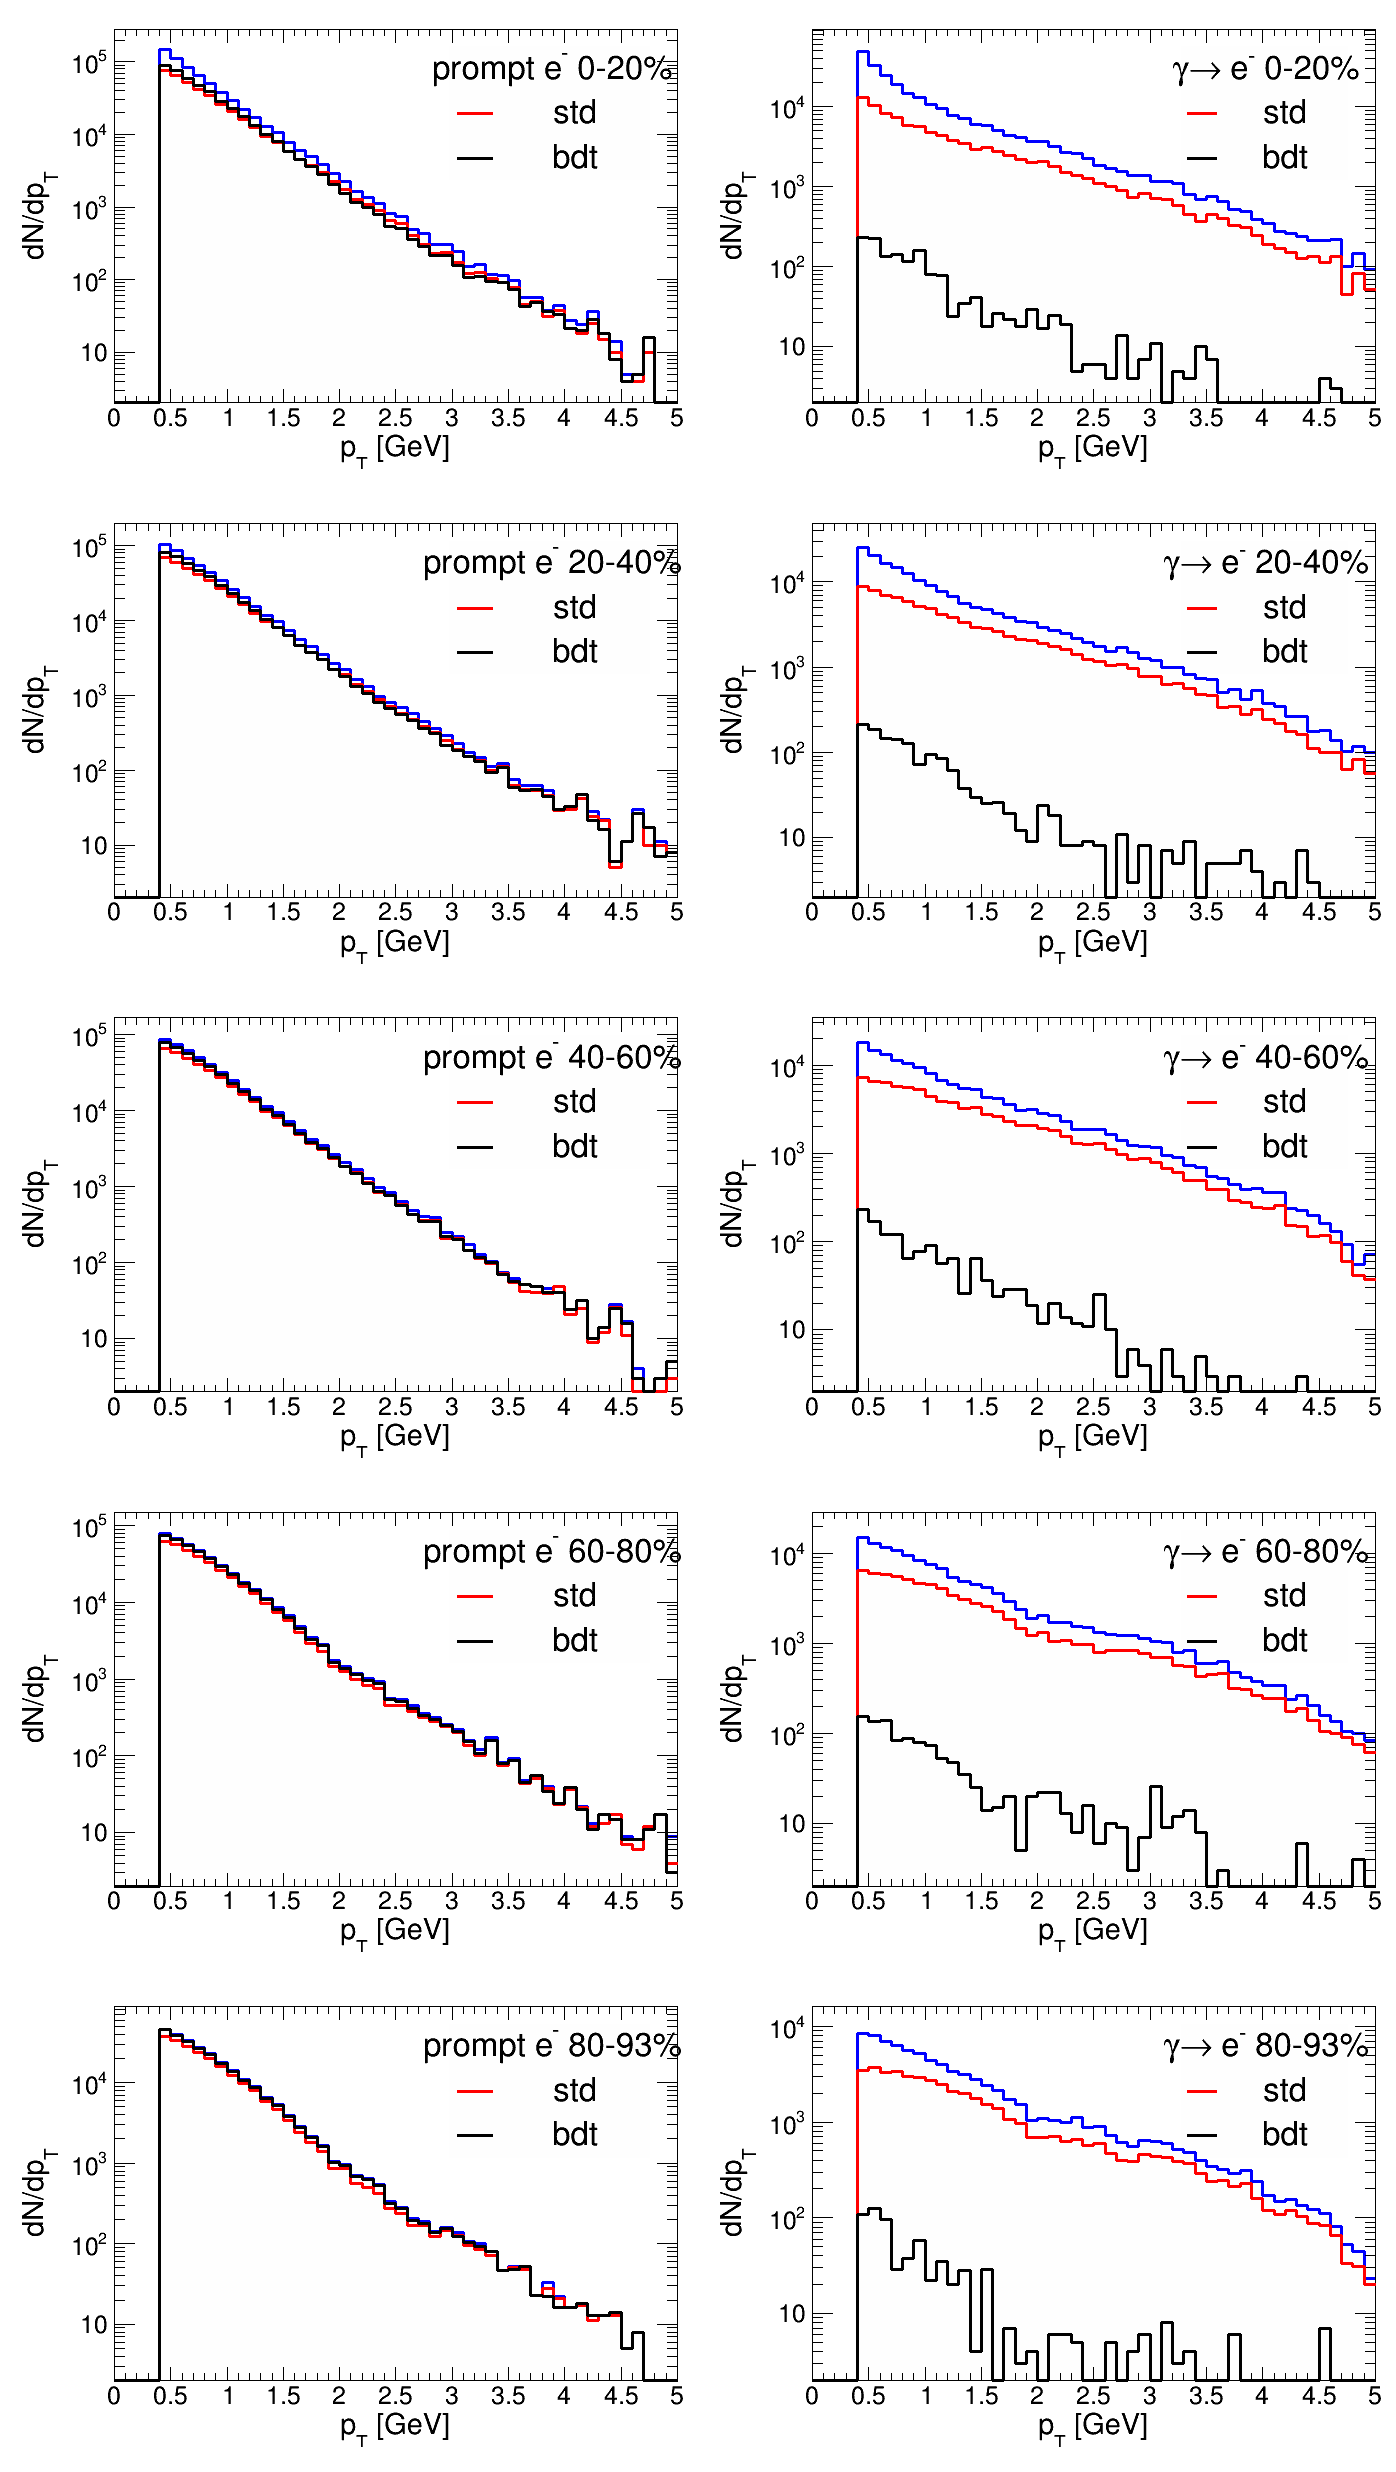

In [ ]:
c1 = root.TCanvas("c1","c1",1400,2500)
c1.Divide(2,5)
part_names_legend= [ "prompt e^{-} " , "#gamma#rightarrow e^{-} "]
centralities_legend = ["0-20%","20-40%","40-60%","60-80%","80-93%"]
legends = []
for icentr in range(5):

    c1.cd(1+2*icentr)
    root.gPad.SetLogy()
    e_pt_hist_NC.ProjectionX(f"e_pt_hist_NC_{icentr}").SetLineWidth(3)
    e_pt_hist_SC.ProjectionX(f"e_pt_hist_SC_{icentr}").SetLineWidth(3)
    e_pt_hist_AI.ProjectionX(f"e_pt_hist_AI_{icentr}").SetLineWidth(3)
    e_pt_hist_NC.SetLineColor(4)
    e_pt_hist_SC.SetLineColor(2)
    e_pt_hist_AI.SetLineColor(1)
    proj = e_pt_hist_NC.ProjectionX(f"e_pt_hist_NC_{icentr}",2*icentr+1,2*icentr+2)
    proj.SetMinimum(2)
    Format_Hist_total(proj, title_x="p_{T} [GeV]",  title_y="dN/dp_{T}", left=0.15, bottom=0.15, right=0.01, top=0.01,  Tsize=0.07,  Lsize=0.06,\
                      Mstyle=21,  Msize=2, Mcolor=4,  Lwidth=3,  Lcolor=4,  offset_x=1, offset_y=1, title="",  Malpha=1,  Lalpha=1)
    proj.Draw()
    e_pt_hist_SC.ProjectionX(f"e_pt_hist_SC_{icentr}",2*icentr+1,2*icentr+2).Draw("same")
    e_pt_hist_AI.ProjectionX(f"e_pt_hist_AI_{icentr}",2*icentr+1,2*icentr+2).Draw("same")

    legends.append(Draw_Legend_Title(0.65,0.65,0.95,0.95,part_names_legend[0]+centralities_legend[icentr],TextSize=0.08, align =22, LineWidth=0, Color=1,  alpha=0))
    legends[-1].AddEntry(e_pt_hist_SC.ProjectionX(f"e_pt_hist_SC_{icentr}",2*icentr+1,2*icentr+2),"std","l")
    legends[-1].AddEntry(e_pt_hist_AI.ProjectionX(f"e_pt_hist_AI_{icentr}",2*icentr+1,2*icentr+2),"bdt","l")
    legends[-1].Draw()

    c1.cd(2+2*icentr)
    root.gPad.SetLogy()
    h_pt_hist_NC.ProjectionX(f"h_pt_hist_NC_{icentr}").SetLineWidth(3)
    h_pt_hist_SC.ProjectionX(f"h_pt_hist_SC_{icentr}").SetLineWidth(3)
    h_pt_hist_AI.ProjectionX(f"h_pt_hist_AI_{icentr}").SetLineWidth(3)
    h_pt_hist_NC.SetLineColor(4)
    h_pt_hist_SC.SetLineColor(2)
    h_pt_hist_AI.SetLineColor(1)
    projh = h_pt_hist_NC.ProjectionX(f"h_pt_hist_NC_{icentr}",2*icentr+1,2*icentr+2)
    Format_Hist_total(projh, title_x="p_{T} [GeV]",  title_y="dN/dp_{T}", left=0.15, bottom=0.15, right=0.01, top=0.01,  Tsize=0.07,  Lsize=0.06,\
                      Mstyle=21,  Msize=2, Mcolor=4,  Lwidth=3,  Lcolor=4,  offset_x=1, offset_y=1, title="",  Malpha=1,  Lalpha=1)
    projh.SetMinimum(2)
    projh.Draw()
    h_pt_hist_SC.ProjectionX(f"h_pt_hist_SC_{icentr}",2*icentr+1,2*icentr+2).Draw("same")
    h_pt_hist_AI.ProjectionX(f"h_pt_hist_AI_{icentr}",2*icentr+1,2*icentr+2).Draw("same")

    legends.append(Draw_Legend_Title(0.7,0.65,0.95,0.95,part_names_legend[1]+centralities_legend[icentr],TextSize=0.08, align =22, LineWidth=0, Color=1,  alpha=0))
    legends[-1].AddEntry(h_pt_hist_SC.ProjectionX(f"h_pt_hist_SC_{icentr}",2*icentr+1,2*icentr+2),"std","l")
    legends[-1].AddEntry(h_pt_hist_AI.ProjectionX(f"h_pt_hist_AI_{icentr}",2*icentr+1,2*icentr+2),"bdt","l")
    legends[-1].Draw()
c1.Draw()
print(h_pt_hist_NC.GetBinContent(10,1),e_pt_hist_NC.GetBinContent(10,1))

In [ ]:
if False:
    e_pt_hist_AI.Write()
    h_pt_hist_AI.Write()
    e_pt_hist_SC.Write()
    h_pt_hist_SC.Write()
    e_pt_hist_NC.Write()
    h_pt_hist_NC.Write()
    outfile.Close()

In [ ]:
import pickle
with open('output/bdt_conv.pkl','wb') as f:
    pickle.dump(clf,f)

print(clf.predict(kek_data[0:10]))

[0 0 0 0 0 0 0 0 0 0]


In [ ]:
import pickle
# load
with open('output/bdt_conv.pkl', 'rb') as f:
    clf2 = pickle.load(f)
print(clf2.predict(kek_data[0:10]))

NameError: name 'kek_data' is not defined

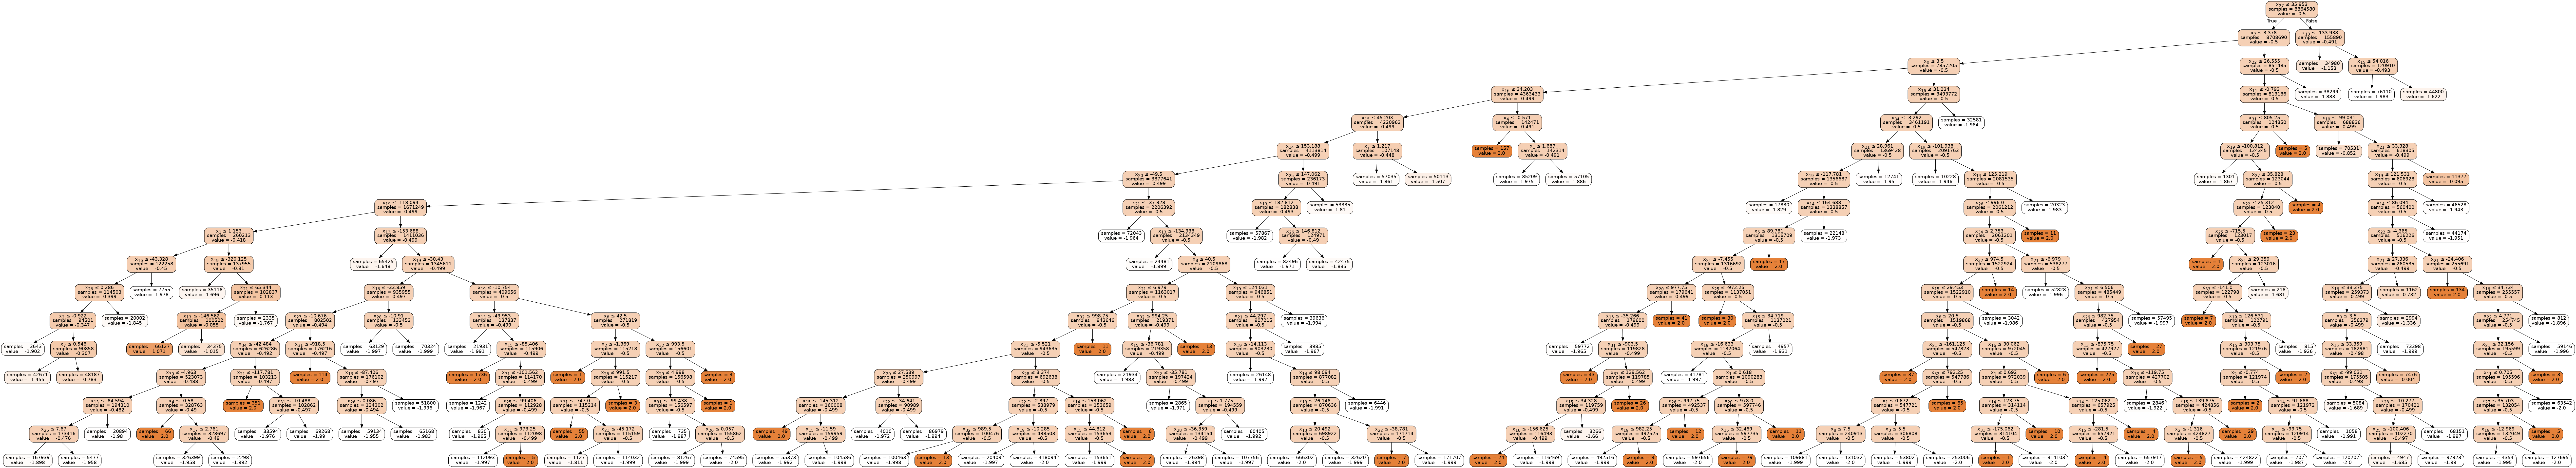

In [ ]:
sub_tree_42 = clf2.best_estimator_[0, 0]
from sklearn.tree import export_graphviz, export_text
from sklearn.tree import _tree
# Visualization
# Install graphviz: https://www.graphviz.org/download/
from pydotplus import graph_from_dot_data
from IPython.display import Image
dot_data = export_graphviz(
    sub_tree_42,
    out_file=None, filled=True, rounded=True,
    special_characters=True,
    proportion=False, impurity=False, # enable them if you want
)

graph = graph_from_dot_data(dot_data)
png = graph.create_png()
# Save (optional)
from pathlib import Path
Path('output/out.png').write_bytes(png)
# Display
Image(png)

In [ ]:
clf2.predict(kek_data[0:100])

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [ ]:
clf2.predict_proba(kek_data[0:100])

array([[0.99459604, 0.00540396],
       [0.96501066, 0.03498934],
       [0.99541815, 0.00458185],
       [0.99602187, 0.00397813],
       [0.99602306, 0.00397694],
       [0.99518155, 0.00481845],
       [0.99603942, 0.00396058],
       [0.98985872, 0.01014128],
       [0.99608406, 0.00391594],
       [0.99605468, 0.00394532],
       [0.99513268, 0.00486732],
       [0.9960691 , 0.0039309 ],
       [0.98087535, 0.01912465],
       [0.99593723, 0.00406277],
       [0.99570755, 0.00429245],
       [0.99612613, 0.00387387],
       [0.99530181, 0.00469819],
       [0.99595613, 0.00404387],
       [0.99609554, 0.00390446],
       [0.99605312, 0.00394688],
       [0.45008581, 0.54991419],
       [0.98633895, 0.01366105],
       [0.97574597, 0.02425403],
       [0.99454367, 0.00545633],
       [0.9960868 , 0.0039132 ],
       [0.98876699, 0.01123301],
       [0.99595997, 0.00404003],
       [0.99466193, 0.00533807],
       [0.99590262, 0.00409738],
       [0.99610496, 0.00389504],
       [0.

In [ ]:
print( clf2.best_params_)

{'criterion': 'squared_error', 'learning_rate': 0.2, 'loss': 'log_loss', 'max_depth': 16, 'max_features': 'sqrt', 'min_samples_split': 0.01, 'n_estimators': 24}


In [ ]:
clf2.best_estimator_.predict_proba(kek_data[9:20])

array([[0.99605468, 0.00394532],
       [0.99513268, 0.00486732],
       [0.9960691 , 0.0039309 ],
       [0.98087535, 0.01912465],
       [0.99593723, 0.00406277],
       [0.99570755, 0.00429245],
       [0.99612613, 0.00387387],
       [0.99530181, 0.00469819],
       [0.99595613, 0.00404387],
       [0.99609554, 0.00390446],
       [0.99605312, 0.00394688]])

In [ ]:
y = clf2.best_estimator_[0, 0].predict(kek_data[9:19].values.tolist())*0
#y = gb_clf.decision_function(kek_data[9:20])

rate = clf2.best_params_['learning_rate']
print(rate)
for i in range(0,10):
    sub_tree = clf2.best_estimator_[i, 0]
    y += rate*sub_tree.predict(kek_data[9:19].values.tolist())
print(y)
print(gb_clf.decision_function(kek_data[9:20]))
z=y
for i in range(len(z)): 
    z[i] = 1./(1+np.exp(-z[i]))
print(z)

0.2
[-2.69264927 -2.68496425 -2.69202636 -2.59745982 -2.68976052 -2.68681722
 -2.69413807 -2.68383444 -2.69163228 -2.69265343]
[-8.54479664 -8.91303345 -8.37169176 -8.49808406 -8.45156408 -8.31597278
 -8.49808406 -8.77455315 -8.39444649 -9.30432815 -8.41167536]
[0.0634085  0.06386643 0.06344551 0.06930208 0.06358027 0.06375574
 0.06332014 0.06393401 0.06346893 0.06340825]


In [ ]:
best_gbc = clf2.best_estimator_

In [ ]:
n_estim = best_gbc.n_estimators

In [ ]:
learning_rate = best_gbc.learning_rate
print(clf2.decision_function(kek_data[9:19]))
arr = clf2.decision_function(kek_data[9:19])
print(1./(1.+np.exp(-arr)))
#tree_scores = [best_gbc.estimators_[i, 0].decision_function(kek_data[9:19].values.tolist()) for i in range(10)]
print(learning_rate)

[-5.53127161 -5.32033299 -5.5349473  -3.93746741 -5.5018198  -5.4465951
 -5.54962056 -5.35586806 -5.50650034 -5.54172324]
[0.00394532 0.00486732 0.0039309  0.01912465 0.00406277 0.00429245
 0.00387387 0.00469819 0.00404387 0.00390446]
0.2


In [ ]:
log_odds_predictions = []
for tree in clf2.best_estimator_:
    # For each tree, get the predicted values for each sample
    leaf_indices = tree[0].apply(kek_data[9:19].values.tolist())  # Get the leaf indices for the training data
    leaf_values = tree[0].tree_.value  # Get the values at each leaf

    # Average the values for each leaf to interpret them as log odds
    predicted_log_odds = [leaf_values[leaf_indices[i]].mean() for i in range(len(kek_data[9:19]))]
    log_odds_predictions.append(predicted_log_odds)

In [ ]:
print(log_odds_predictions)

[[-1.999498236456516, -1.9991076682561992, -1.9996056042298098, -1.9901221022517122, -1.9995960450659167, -1.994379070795353, -1.9996180978356286, -1.998904873086394, -1.998904873086394, -1.9998276342055796], [-1.669760839580847, -1.668291634749461, -1.669636247635768, -1.5004913159226878, -1.66975705237028, -1.6666968258643822, -1.6703051821933559, -1.66975705237028, -1.6666968258643822, -1.669760839580847], [-1.4797200494609695, -1.4716291447780372, -1.4799104801388583, -1.4627048061298964, -1.4734360244271392, -1.475597961649068, -1.4788020048304902, -1.4734360244271392, -1.4789687183550793, -1.4797022379755933], [-1.3557149453801696, -1.3509529700574507, -1.3563944886177934, -1.3509853056877295, -1.354387637702204, -1.354387637702204, -1.3568559978186479, -1.343526572818689, -1.3561950539253573, -1.3568559978186479], [-1.271996904629492, -1.2682194248134846, -1.2719225294534238, -1.1621199059763945, -1.2682194248134846, -1.2704746728504213, -1.2717492253850626, -1.2709857428666018,

In [ ]:
rate = clf2.best_params_['learning_rate']
myarr = [log_odds_predictions[i][0] for i in range(10)]
print(rate,rate*sum(myarr))
print(clf2.decision_function(kek_data[9:19]))

0.2 -2.6926492721615114
[-5.53127161 -5.32033299 -5.5349473  -3.93746741 -5.5018198  -5.4465951
 -5.54962056 -5.35586806 -5.50650034 -5.54172324]


In [ ]:
print(best_gbc.estimators_.shape[0])
print(best_gbc.estimators_.shape[1])
y = []
for i in range(10):
    y0=[]
    for j in range(n_estim):
        sub_tree = clf2.best_estimator_[j, 0]
        y0.append(sub_tree.predict(kek_data[9+i:10+i].values.tolist())[0])
    y.append(y0)
print(y)

24
1
[[-1.999498236456516, -1.669760839580847, -1.4797200494609695, -1.3557149453801696, -1.271996904629492, -1.2107785825719293, -1.1648102776287768, -1.1299523820713135, -1.1043570512719274, -1.0766570917556155, -1.0603689053664562, -1.053968789892661, -1.0416204540550598, -1.0337432791377243, -1.0223217273120102, -1.014477522178054, -1.0087518802600244, -1.0117155209092428, -1.0101430734985106, -0.9719611600592913, -0.9955947064894035, -0.9974845399504597, -0.9954012633626437, -0.9755588749044811], [-1.9991076682561992, -1.668291634749461, -1.4716291447780372, -1.3509529700574507, -1.2682194248134846, -1.2070322371546829, -1.1612525627084902, -1.1196711919063747, -1.1022478364011428, -1.0764165722634693, -1.066614806101654, -1.0405192713457103, -1.0263755899219347, -1.0260323644653455, -1.0223217273120102, -0.9744794348082455, -0.8266306389971076, -1.005769808540173, -0.9663037240186334, -0.9756019911908461, -0.8782540124264571, -0.7380475749186146, -0.7245206750550206, -0.905372102

In [ ]:
def get_rules(tree, feature_names, class_names):
    tree_ = tree.tree_
    feature_name = [
        #feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        f'x[{i}]' if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []
    
    def recurse(node, path, paths):
        
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, 5)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {np.round(threshold, 5)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]
            
    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]
    
    rules = []
    for path in paths:
        rule = "if ( "
        
        for p in path[:-1]:
            if rule != "if ( ":
                rule += " && "
            rule += str(p)
        rule += " ) "
        if class_names is None:
            rule += " return "+str(np.round(path[-1][0][0][0],30))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"class: {class_names[l]} (proba: {np.round(100.0*classes[l]/np.sum(classes),20)}%)"
        rule += f";  // | based on {path[-1][1]:,} samples"
        rules += [rule]
        
    return rules


In [ ]:
import numpy as np
from sklearn.tree import _tree
def get_rules(tree, feature_names, class_names):
    tree_ = tree.tree_
    feature_name = [
        #feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        f'x[{i}]' if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []
    
    def recurse(node, path, paths):
        
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, 5)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {np.round(threshold, 5)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]
            
    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]
    
    rules = []
    for path in paths:
        rule = "if  "
        
        for p in path[:-1]:
            if rule != "if  ":
                rule += " if "
            rule += str(p)
        rule += "  "
        if class_names is None:
            rule += " return "+str(np.round(path[-1][0][0][0],30))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"class: {class_names[l]} (proba: {np.round(100.0*classes[l]/np.sum(classes),20)}%)"
        rule += f";  // | based on {path[-1][1]:,} samples"
        rules += [rule]
        
    return rules

In [ ]:
#print(f"double mytree{list(kek_data.columns)}")
print('{')
for iestim in range(n_estim):
    print(f"    if (iestim == {iestim})")
    print('    {')
    sub_tree = clf2.best_estimator_[iestim, 0]
    rules = get_rules(sub_tree, list(kek_data.columns), None)
    for r in rules:
        print("       ",r)
    print('    }')
print ('    return -9999;')
print('};')

{
    if (iestim == 0)
    {
        if  (x[27] <= 35.95312) if (x[7] <= 3.37793) if (x[0] <= 3.5) if (x[16] <= 34.20312) if (x[15] <= 45.20312) if (x[14] <= 153.1875) if (x[20] > -49.49998) if (x[21] > -37.32812) if (x[13] > -134.9375) if (x[8] > 40.5) if (x[19] <= 124.03125) if (x[21] <= 44.29688) if (x[19] > -14.11328) if (x[14] <= 98.09375) if (x[19] <= 26.14844) if (x[13] <= 20.49219)   return -1.9998276342055794;  // | based on 666,302 samples
        if  (x[27] <= 35.95312) if (x[7] <= 3.37793) if (x[0] > 3.5) if (x[16] <= 31.23438) if (x[34] > -3.29199) if (x[19] > -101.9375) if (x[14] <= 125.21875) if (x[26] <= 996.0) if (x[34] <= 2.75293) if (x[32] <= 974.5) if (x[15] <= 29.45312) if (x[8] > 20.5) if (x[16] <= 30.0625) if (x[1] > 0.69165) if (x[14] <= 125.0625) if (x[15] > -281.5)   return -1.9999432739229221;  // | based on 657,917 samples
        if  (x[27] <= 35.95312) if (x[7] <= 3.37793) if (x[0] > 3.5) if (x[16] <= 31.23438) if (x[34] <= -3.29199) if (x[21] <= 28.96094)

In [ ]:
def get_rules(tree, feature_names, class_names):
    tree_ = tree.tree_
    feature_name = [
        f'x[{i}]' if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []
    
    def recurse(node, path, paths):
        
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, 5)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {np.round(threshold, 5)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]
            
    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]
    
    rules = []
    for path in paths:
        rule = "if "
        
        for p in path[:-1]:
            if rule != "if ":
                rule += " and "
            rule += str(p)
        rule += " : "
        if class_names is None:
            rule += " return "+str(np.round(path[-1][0][0][0],30))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"class: {class_names[l]} (proba: {np.round(100.0*classes[l]/np.sum(classes),20)}%)"
        rule += f"  # | based on {path[-1][1]:,} samples"
        rules += [rule]
        
    return rules


In [ ]:
print(f"def mytree( iestim,  x ) :")
for iestim in range(n_estim):
    print(f"    if iestim == {iestim}:")
    sub_tree = clf2.best_estimator_[iestim, 0]
    rules = get_rules(sub_tree, list(kek_data.columns), None)
    for r in rules:
        print("       ",r)
print ('    return -9999')

def mytree( iestim,  x ) :
    if iestim == 0:
        if (x[27] <= 35.95312) and (x[7] <= 3.37793) and (x[0] <= 3.5) and (x[16] <= 34.20312) and (x[15] <= 45.20312) and (x[14] <= 153.1875) and (x[20] > -49.49998) and (x[21] > -37.32812) and (x[13] > -134.9375) and (x[8] > 40.5) and (x[19] <= 124.03125) and (x[21] <= 44.29688) and (x[19] > -14.11328) and (x[14] <= 98.09375) and (x[19] <= 26.14844) and (x[13] <= 20.49219) :  return -1.9998276342055794  # | based on 666,302 samples
        if (x[27] <= 35.95312) and (x[7] <= 3.37793) and (x[0] > 3.5) and (x[16] <= 31.23438) and (x[34] > -3.29199) and (x[19] > -101.9375) and (x[14] <= 125.21875) and (x[26] <= 996.0) and (x[34] <= 2.75293) and (x[32] <= 974.5) and (x[15] <= 29.45312) and (x[8] > 20.5) and (x[16] <= 30.0625) and (x[1] > 0.69165) and (x[14] <= 125.0625) and (x[15] > -281.5) :  return -1.9999432739229221  # | based on 657,917 samples
        if (x[27] <= 35.95312) and (x[7] <= 3.37793) and (x[0] > 3.5) and (x[16] <= 31.23438)

In [ ]:
def mytree(x,y):
    return 0

In [ ]:
def mygradboost (x, lerning_rate = 0.2):
    prob = 0
    for i in range (n_estim):
        prob+=lerning_rate*mytree(i, x)
    return 1. / ( 1. + np.exp( - prob ) )


In [ ]:
def mybdt(x, prob):
    if mygradboost(x)>prob: return 1
    return  

In [ ]:
iestim = 9
sub_tree = clf2.best_estimator_[iestim, 0]
y = sub_tree.predict(kek_data[9:19].values.tolist())
print(y)

myf = [mytree(iestim, kek_data[9+i:10+i].values.tolist()[0]) for i in range(10)]
print(myf)

[-1.07665709 -1.07641657 -1.07793306 -1.07665709 -1.08209838 -1.07793306
 -1.08319744 -1.08319744 -1.08319744 -1.07665709]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
iestim = 9
sub_tree = clf2.best_estimator_
y = sub_tree.predict_proba(kek_data[9:19].values.tolist())
print(y)

myf = [mygradboost(kek_data[9+i:10+i].values.tolist()[0]) for i in range(10)]
print(myf)

[[0.99605468 0.00394532]
 [0.99513268 0.00486732]
 [0.9960691  0.0039309 ]
 [0.98087535 0.01912465]
 [0.99593723 0.00406277]
 [0.99570755 0.00429245]
 [0.99612613 0.00387387]
 [0.99530181 0.00469819]
 [0.99595613 0.00404387]
 [0.99609554 0.00390446]]
[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]


/home/yoren/.local/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


In [ ]:
column_headers = list(kek_data.columns.values)
print(column_headers)
print(len(column_headers))

['NBDThit', 'Pt', 'Phi0', 'The0', 'PhiDC', 'ZDC', 'Alpha', 'Ecore', 'Centrality', 'Charge', 'Arm', 'sdphi0', 'sdthe0', 'SecondHitPhiR0', 'SecondHitPhiL0', 'SecondHitTheR0', 'SecondHitTheL0', 'sdphi1', 'sdthe1', 'SecondHitPhiR1', 'SecondHitPhiL1', 'SecondHitTheR1', 'SecondHitTheL1', 'sdphi2', 'sdthe2', 'SecondHitPhiR2', 'SecondHitPhiL2', 'SecondHitTheR2', 'SecondHitTheL2', 'sdphi3', 'sdthe3', 'SecondHitPhiR3', 'SecondHitPhiL3', 'SecondHitTheR3', 'SecondHitTheL3']
35
